# Chapter 7: Ensemble Learning and Random Forests

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import loguniform, mode
from sklearn.datasets import fetch_openml
from sklearn.ensemble import (
    ExtraTreesClassifier,
    RandomForestClassifier,
    VotingClassifier,
)
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

plt.style.use("dark_background")

1. Suppose you've trained 5 different models on the same training data and each achieves a 95% precision. You could combine them using hard voting, wherein the predicted class is given by the majority of the classifiers (or soft voting if all the classifiers have a `predict_proba` method). However, this won't necessarily yield a better result if the models are very similar (i.e. all decision trees with the same hyperparameters).
2. Hard voting gives returns the majority vote of the ensemble, whereas soft voting returns the class with the highest average probability by taking an average over each of the estimators predicted class probabilities.
3. For bagging & pasting, predictors can be trained in parallel on separate servers to speed up training. A random forest is just an ensemble of decision trees trained via bagging or pasting, therefore the training of random forests can be sped up by distributing it across multiple servers. Boosting involves training weak predictors sequentially so does not benefit from parallelization. For a stacking ensemble, the predictors in each layer are independent of one another so can benefit from parallelization however each layer must be trained sequentially.
4. Out-of-bag evaluation: each predictor in a bagging ensemble is evaluated on instances it was not trained on. This makes it possible to have a fairly unbiased evaluation of the ensemble without the need for an additional validation set.
5. Extra-trees ensembles don't find the optimal splits, instead splits are made that meet a random threshold. This makes them much faster to train and the randomness introduces an element of regularization.
6. If an AdaBoost ensemble underfits the training data, increase the number of estimators or reduce the regularization hyperparameters of the base estimator. You can also try slightly increasing the learning rate.
7. If a gradient boosting ensemble overfits the training data you should decrease the learning rate. You could also try early stopping (i.e. using fewer predictors).

*bagging vs. pasting* - both bagging and pasting allow training instances to be sampled several times across multiple predictors, but only bagging allows training instances to be sampled several times for the same predictor.


## 8. Voting Classification for MNIST

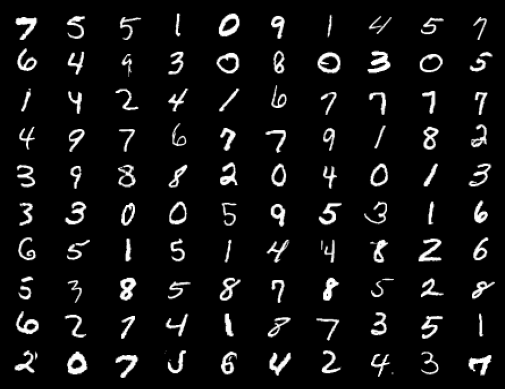

X_train.shape: (50000, 784)
X_val.shape: (10000, 784)
X_test.shape: (10000, 784)


In [2]:
mnist = fetch_openml("mnist_784", as_frame=False, parser="auto")
X, y = mnist.data, mnist.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10_000)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10_000)


def plot_digit(image_data):
    plt.imshow(image_data.reshape(28, 28), cmap="binary_r")
    plt.axis("off")


plt.figure()
for idx, image_data in enumerate(X_train[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data)

plt.show()

print(
    f"X_train.shape: {X_train.shape}",
    f"X_val.shape: {X_val.shape}",
    f"X_test.shape: {X_test.shape}",
    sep="\n",
)

### 8.a. KNeighborsClassifier

In [3]:
knn_classifier = GridSearchCV(
    KNeighborsClassifier(
        p=1,
        weights="distance",
        algorithm="ball_tree",
        n_jobs=-1,
    ),
    {"n_neighbors": [3, 4, 5, 6]},
    cv=3,
    n_jobs=-1,
    scoring="accuracy",
)
knn_classifier.fit(X_train[:3_000], y_train[:3_000])

GridSearchCV(cv=3,
             estimator=KNeighborsClassifier(algorithm='ball_tree', n_jobs=-1,
                                            p=1, weights='distance'),
             n_jobs=-1, param_grid={'n_neighbors': [3, 4, 5, 6]},
             scoring='accuracy')

In [4]:
model_scores = {"model": [], "val_accuracy": [], "y_val_pred": []}


def eval_grid_search(grid_search_model, refit=False):
    print(
        f"Best params: {grid_search_model.best_params_}",
        f"Best score: {grid_search_model.best_score_}",
        sep="\n",
    )
    y_val_pred = grid_search_model.predict(X_val)
    score = accuracy_score(y_val, y_val_pred)
    print(
        f"Score on validation set: {score}",
        sep="\n",
    )
    if refit:
        print("Refitting on whole training set")
        grid_search_model.best_estimator_.fit(X_train, y_train)
        y_val_pred = grid_search_model.predict(X_val)
        score = accuracy_score(y_val, y_val_pred)
        print(f"Score on validation set: {score}")

    model_scores["model"].append(grid_search_model.best_estimator_.__class__.__name__)
    model_scores["val_accuracy"].append(score)
    model_scores["y_val_pred"].append(y_val_pred)


eval_grid_search(knn_classifier)

Best params: {'n_neighbors': 4}
Best score: 0.9033333333333333
Score on validation set: 0.9161


### 8.b. SVC

In [5]:
svm_classifier = RandomizedSearchCV(
    make_pipeline(MinMaxScaler(), SVC()),
    {"svc__C": loguniform(0.01, 100), "svc__gamma": loguniform(0.0001, 1)},
    n_iter=20,
    cv=3,
    n_jobs=-1,
    scoring="accuracy",
)
svm_classifier.fit(X_train[:3_000], y_train[:3_000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                             ('svc', SVC())]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'svc__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x1176f2b00>,
                                        'svc__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x15d587010>},
                   scoring='accuracy')

In [6]:
eval_grid_search(svm_classifier)

Best params: {'svc__C': 4.30023383536379, 'svc__gamma': 0.021552434006680384}
Best score: 0.9380000000000001
Score on validation set: 0.9467


### 8.c. RandomForestClassifier

In [7]:
random_forest_classifier = RandomizedSearchCV(
    RandomForestClassifier(n_jobs=-1),
    {
        "n_estimators": [100 * _ for _ in range(1, 21)],
        "max_features": loguniform(0.01, 0.05),
        "max_depth": range(5, 30),
    },
    n_iter=20,
    cv=3,
    n_jobs=-1,
    scoring="accuracy",
)
random_forest_classifier.fit(X_train[:3_000], y_train[:3_000])

/opt/miniconda3/envs/tf-env/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'max_depth': range(5, 30),
                                        'max_features': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x15d586f80>,
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100, 1200,
                                                         1300, 1400, 1500, 1600,
                                                         1700, 1800, 1900,
                                                         2000]},
                   scoring='accuracy')

In [8]:
eval_grid_search(random_forest_classifier, refit=True)

Best params: {'max_depth': 17, 'max_features': 0.020128983781038272, 'n_estimators': 1900}
Best score: 0.9256666666666667
Score on validation set: 0.9322
Refitting on whole training set
Score on validation set: 0.9658


### 8.d. ExtraTreesClassifier

In [9]:
extra_tree_classifier = RandomizedSearchCV(
    ExtraTreesClassifier(n_jobs=-1),
    {
        "n_estimators": [100 * _ for _ in range(1, 21)],
        "max_features": loguniform(0.01, 0.05),
        "max_depth": range(5, 30),
    },
    n_iter=20,
    cv=3,
    n_jobs=-1,
    scoring="accuracy",
)
extra_tree_classifier.fit(X_train[:3_000], y_train[:3_000])

/opt/miniconda3/envs/tf-env/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=3, estimator=ExtraTreesClassifier(n_jobs=-1), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'max_depth': range(5, 30),
                                        'max_features': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x16bc5dc90>,
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100, 1200,
                                                         1300, 1400, 1500, 1600,
                                                         1700, 1800, 1900,
                                                         2000]},
                   scoring='accuracy')

In [10]:
eval_grid_search(extra_tree_classifier, refit=True)

Best params: {'max_depth': 22, 'max_features': 0.028367434427987337, 'n_estimators': 1300}
Best score: 0.931
Score on validation set: 0.9402
Refitting on whole training set
Score on validation set: 0.9716


In [11]:
pd.DataFrame(model_scores)

,model,val_accuracy,y_val_pred
0,KNeighborsClassifier,0.9161,"[4, 4, 8, 6, 0, 8, 6, 7, 2, 3, 7, 3, 9, 1, 1, ..."
1,Pipeline,0.9467,"[4, 4, 8, 6, 0, 8, 6, 7, 2, 3, 2, 3, 9, 1, 1, ..."
2,RandomForestClassifier,0.9658,"[4, 4, 8, 6, 0, 8, 6, 7, 2, 3, 2, 3, 9, 1, 1, ..."
3,ExtraTreesClassifier,0.9716,"[4, 4, 8, 6, 0, 8, 6, 7, 2, 3, 2, 3, 9, 1, 1, ..."


In [12]:
votes = np.vstack(model_scores["y_val_pred"]).T
y_val_pred = mode(votes.astype("int"), axis=1).mode.astype("str")
accuracy_score(y_val, y_val_pred)

0.9661

## 9. Stacking Classification for MNIST

In [13]:
blender = RandomizedSearchCV(
    make_pipeline(MinMaxScaler(), SVC()),
    {"svc__C": loguniform(0.01, 100), "svc__gamma": loguniform(0.0001, 1)},
    n_iter=20,
    cv=3,
    n_jobs=-1,
    scoring="accuracy",
    verbose=3,
)

blender.fit(votes.astype("int"), y_val)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 2/3] END svc__C=93.36589065185142, svc__gamma=0.027652019939917217;, score=0.967 total time=   0.9s
[CV 1/3] END svc__C=93.36589065185142, svc__gamma=0.027652019939917217;, score=0.963 total time=   0.9s
[CV 3/3] END svc__C=93.36589065185142, svc__gamma=0.027652019939917217;, score=0.969 total time=   1.1s
[CV 1/3] END svc__C=0.2368267201607787, svc__gamma=0.5376836534381999;, score=0.927 total time=   1.5s
[CV 2/3] END svc__C=0.2368267201607787, svc__gamma=0.5376836534381999;, score=0.937 total time=   1.4s
[CV 3/3] END svc__C=0.2368267201607787, svc__gamma=0.5376836534381999;, score=0.934 total time=   1.5s
[CV 2/3] END svc__C=0.012642333469473672, svc__gamma=0.06156490989865772;, score=0.206 total time=   5.1s
[CV 3/3] END svc__C=0.012642333469473672, svc__gamma=0.06156490989865772;, score=0.204 total time=   5.3s
[CV 1/3] END svc__C=0.016328026048934335, svc__gamma=0.002817712350048387;, score=0.108 total time=   5.3s

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                             ('svc', SVC())]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'svc__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x16bdbae60>,
                                        'svc__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x16bdba290>},
                   scoring='accuracy', verbose=3)

In [14]:
blender.best_score_

0.9666003792940782